# Машинное обучение, DS-поток, осень 2024
## Задание ML.11


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.

**Баллы за задание**  
Задача 1 &mdash; **190 баллов**  

Всего &mdash; **190 баллов**  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from shutil import copyfile
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import f1_score

import torch
import torchvision
import shutil
from torch import nn
from torchvision import transforms

import wandb
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from torchmetrics.classification import F1Score

from torchvision.models import resnet50

In [2]:
sns.set(style='darkgrid', palette='Set2')
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ermolaevfedor (juequ). Use `wandb login --relogin` to force relogin


True

In [3]:
# Bot check

# HW_ID: ds_ml11
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

### 0. Инструкция Pytorch Lightning + WandB

Это задание нужно выполнять, используя Pytorch Lightning совместно с WandB.

1. Обучение каждой из моделей должно идти с отдельным запуском в WandB. Если вы закончили всю работу с данной моделью (включая тестирование), не забывайте завершать запуск с помощью `wandb.finish()`.


2. **Важно**: Делать скрины с [wandb.ai](https://wandb.ai) и вставлять ссылки на [wandb.ai](https://wandb.ai) крайне не приветствуется и может караться. Не создавайте ссылок на ваш проект &mdash; он должен быть приватным! Вместо этого, смотрите пункт [Визуализация запусков и выводы](#vis).

3. Если вы сделали задание только частично, все равно визуализируйте имеющиеся запуски в пункте [Визуализация запусков и выводы](#vis).





## Задача 1. Transfer learning
Вы научите нейронную сеть классифицировать произведения искусства различных художников, т.е. определять к какому художнику относится картина.

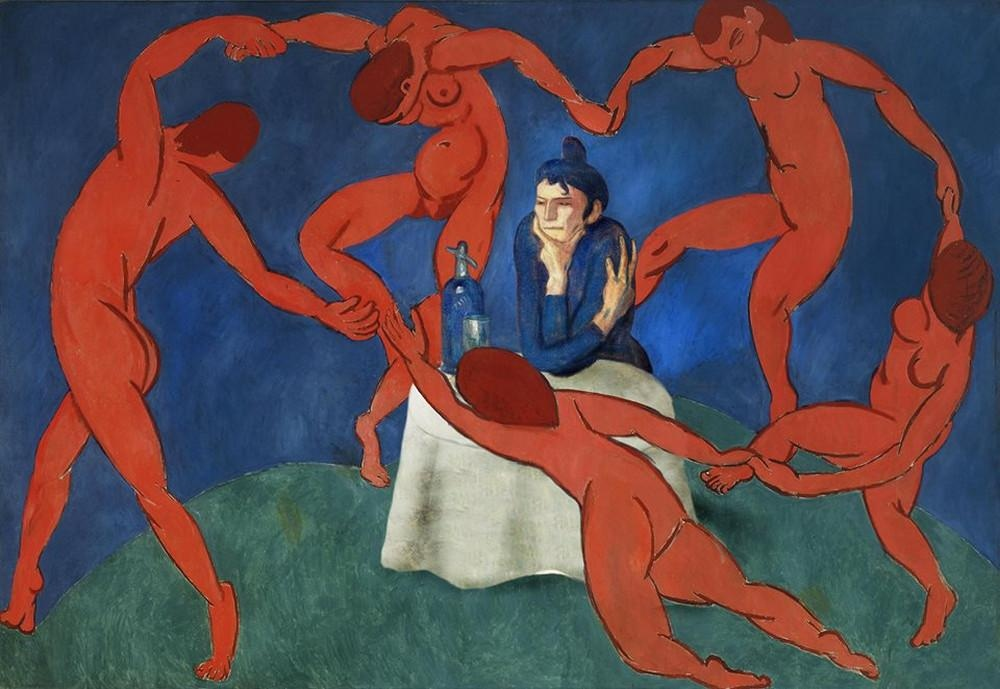

### 1. Данные
Скачайте архив с датасетом по [ссылке](https://disk.yandex.ru/d/_BUueJa4RVXplQ).

Если вы работаете в **Google Colab**, то удобнее всего будет скачать архив на Google Drive (диск). В таком случае не придестя загружать архив вручную каждый раз, когда обрывается runtime. Для этого перейдите в левую  боковую панель, нажмите на кнопку с папочкой, а затем на кнопку с папочкой с изображением Google Drive. Теперь все файлы с диска доступны по пути `drive/MyDrive/`.

Если вы работаете в **Kaggle**, то для того, чтобы загрузить данные, перейдите в правую боковую панель. В разделе `Data` возле кнопки `Add Data` расположена кнопка загрузки данных. Нажмите на нее, появится панель `Create a New Dataset`. Назовите новый датасет. Загрузите туда архив.  После того, как датасет будет проверен, он повится у вас в датасетах. Для того, чтобы начать с ним работать в ноутбуке в Kaggle нужно снова перейти в раздел `Data` и нажать `Add Data`. Затем нажмите кнопку `Your Datasets` и нажмите на плюс возле вашего датасета. После этго датасет появится в а разделе `Data`. Причем **Kaggle** разархивирует данные за вас.

Для того, чтобы разархивировать данные, выполните следующие действия.

In [4]:
# Запишите путь до архива.
# zip_path = 'artworks.zip'
# Замените пробелы в пути, чтобы следующая bash-команда работала корректно.
# zip_path_bash = str(zip_path).replace(' ', '\ ')
# Разархивируйте файлы.
# !unzip $zip_path_bash -d .
# Укажите путь до данных.
data_path = Path('./artworks')

Данные содержат папку с изображениями `images` и таблицу с основной информацией про художников `artists.csv`. Папка `images` в свою очередь состоит из папок `train` и `test` с обучающим и тестовым наборами данных соответственно. Рассмотрим, например, папку с тренировочным набором данных.

In [5]:
sorted((data_path / 'images' / 'train').iterdir())

[PosixPath('artworks/images/train/Albrecht_Durer'),
 PosixPath('artworks/images/train/Alfred_Sisley'),
 PosixPath('artworks/images/train/Amedeo_Modigliani'),
 PosixPath('artworks/images/train/Andrei_Rublev'),
 PosixPath('artworks/images/train/Andy_Warhol'),
 PosixPath('artworks/images/train/Camille_Pissarro'),
 PosixPath('artworks/images/train/Caravaggio'),
 PosixPath('artworks/images/train/Claude_Monet'),
 PosixPath('artworks/images/train/Diego_Rivera'),
 PosixPath('artworks/images/train/Diego_Velazquez'),
 PosixPath('artworks/images/train/Edgar_Degas'),
 PosixPath('artworks/images/train/Edouard_Manet'),
 PosixPath('artworks/images/train/Edvard_Munch'),
 PosixPath('artworks/images/train/El_Greco'),
 PosixPath('artworks/images/train/Eugene_Delacroix'),
 PosixPath('artworks/images/train/Francisco_Goya'),
 PosixPath('artworks/images/train/Frida_Kahlo'),
 PosixPath('artworks/images/train/Georges_Seurat'),
 PosixPath('artworks/images/train/Giotto_di_Bondone'),
 PosixPath('artworks/images/t

Она содержит папки, соответствующие художникам в датасете. В каждой такой папке находится тренирвочный набор картин художника.

In [6]:
sorted((data_path / 'images' / 'train' / 'Albrecht_Durer').iterdir())

[PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_001.jpg'),
 PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_002.jpg'),
 PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_004.jpg'),
 PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_005.jpg'),
 PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_006.jpg'),
 PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_007.jpg'),
 PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_008.jpg'),
 PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_010.jpg'),
 PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_011.jpg'),
 PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_012.jpg'),
 PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_013.jpg'),
 PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_016.jpg'),
 PosixPath('artworks/images/train/Albrecht_Durer/Albrecht_Durer_018.jpg'),
 PosixPath('artworks/imag

Приведем примеры изображений.

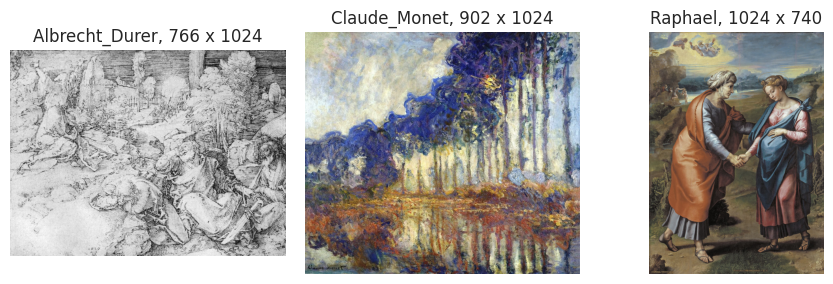

In [7]:
images_paths = [
    data_path / 'images' / 'train' / 'Albrecht_Durer' / 'Albrecht_Durer_310.jpg',
    data_path / 'images' / 'train' / 'Claude_Monet' / 'Claude_Monet_007.jpg',
    data_path / 'images' / 'train' / 'Raphael' / 'Raphael_100.jpg'
]
plt.figure(figsize=(9, 3))
for i, image_path in enumerate(images_paths):
    author = image_path.parent.name
    plt.subplot(1, 3, i + 1)
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.title(f'{author}, {image.shape[0]} x {image.shape[1]}')
    plt.axis("off")
plt.tight_layout()

Заметьте, что все картины разных пропорций и размеров, это нужно учесть при обучении модели. Чтобы привести картины к одному размеру можно использовать аугментации, см. пример с Симпсонами в семинаре.


Теперь посмотрим на таблицу с характеристиками художников.



In [8]:
pd.read_csv(data_path / 'artists.csv')

,name,years,genre,nationality,bio,wikipedia,paintings
0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194
5,Salvador Dali,1904 - 1989,Surrealism,Spanish,Salvador Domingo Felipe Jacinto Dalí i Domènec...,http://en.wikipedia.org/wiki/Salvador_Dalí,139
6,Edouard Manet,1832 - 1883,"Realism,Impressionism",French,Édouard Manet (US: ; UK: ; French: [edwaʁ manɛ...,http://en.wikipedia.org/wiki/Édouard_Manet,90
7,Andrei Rublev,1360 - 1430,Byzantine Art,Russian,"Andrei Rublev (Russian: Андре́й Рублёв, IPA: [...",http://en.wikipedia.org/wiki/Andrei_Rublev,99
8,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...,http://en.wikipedia.org/wiki/Vincent_van_Gogh,877
9,Gustav Klimt,1862 - 1918,"Symbolism,Art Nouveau",Austrian,"Gustav Klimt (July 14, 1862 – February 6, 1918...",http://en.wikipedia.org/wiki/Gustav_Klimt,117


Наша цель &mdash; построить классификатор картин по художникам. В колонке `paintings` указано общее число картин для каждого худодника. Можно заметить большую несбалансированность классов. Поэтому в начале мы будем работать с художниками, для которых в сумме представлено не менее 200 картин.

In [9]:
artists = pd.read_csv(data_path / 'artists.csv')
big_artists = artists[artists['paintings'] >= 200].copy().reset_index().drop(columns = ["index"])
big_artists

,name,years,genre,nationality,bio,wikipedia,paintings
0,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...,http://en.wikipedia.org/wiki/Vincent_van_Gogh,877
1,Pablo Picasso,1881 - 1973,Cubism,Spanish,Pablo Ruiz Picasso (; Spanish: [ˈpaβlo piˈkaso...,http://en.wikipedia.org/wiki/Pablo_Picasso,439
2,Pierre-Auguste Renoir,1841 - 1919,Impressionism,French,"Pierre-Auguste Renoir, commonly known as Augus...",http://en.wikipedia.org/wiki/Pierre-Auguste_Re...,336
3,Francisco Goya,1746 - 1828,Romanticism,Spanish,Francisco José de Goya y Lucientes (; Spanish:...,http://en.wikipedia.org/wiki/Francisco_Goya,291
4,Albrecht Dürer,1471 - 1528,Northern Renaissance,German,Albrecht Dürer (; German: [ˈʔalbʁɛçt ˈdyːʁɐ]; ...,http://en.wikipedia.org/wiki/Albrecht_Dürer,328
5,Alfred Sisley,1839 - 1899,Impressionism,"French,British",Alfred Sisley (; French: [sislɛ]; 30 October 1...,http://en.wikipedia.org/wiki/Alfred_Sisley,259
6,Marc Chagall,1887 - 1985,Primitivism,"French,Jewish,Belarusian",Marc Zakharovich Chagall ( shə-GAHL; born Mois...,http://en.wikipedia.org/wiki/Marc_Chagall,239
7,Edgar Degas,1834 - 1917,Impressionism,French,Edgar Degas (US: or UK: ; born Hilaire-Germai...,http://en.wikipedia.org/wiki/Edgar_Degas,702
8,Rembrandt,1606 - 1669,Baroque,Dutch,Rembrandt Harmenszoon van Rijn (; Dutch: [ˈrɛm...,http://en.wikipedia.org/wiki/Rembrandt,262
9,Titian,1488 - 1576,"High Renaissance,Mannerism",Italian,Tiziano Vecelli or Tiziano Vecellio (pronounce...,http://en.wikipedia.org/wiki/Titian,255


Для обучения вам понадобится построить датасет. Удобнее всего будет воспользоваться `torchvision.datasets.ImageFolder`, см. пример в семинаре с Симпсонами.

In [10]:
input_size = 200

# Трансформация / аугментация для обучающих картинок
train_transform = transforms.Compose([
    transforms.Resize(input_size),         # Меняем размер картинки, наименьшая из сторон становится размера input_size
    transforms.CenterCrop(input_size),     # Вырезаем из центра квадрат размера input_size x input_size
    #transforms.ColorJitter(0.9, 0.9, 0.9), # Меняем случайно цвета
    #transforms.RandomAffine(5),            # Применяем случайное аффинное преобразование
    transforms.ToTensor(),                 # Приводим к тензору
])

# Трансформация для валидации
val_transform = transforms.Compose([
    transforms.Resize(input_size),         # Меняем размер картинки, наименьшая из сторон становится размера input_size
    transforms.CenterCrop(input_size),     # Вырезаем из центра квадрат размера input_size x input_size
    transforms.ToTensor(),                 # Приводим к тензору
])

train_full_dir = data_path / "images" / "train"
val_full_dir = data_path / "images" / "test"

train_full_dataset = torchvision.datasets.ImageFolder(
    train_full_dir,
    transform=train_transform
)

val_full_dataset = torchvision.datasets.ImageFolder(
    val_full_dir,
    transform=val_transform
)

Теперь такой же датасет, но для крупных художников. Предварительно скопируем их картины в отдельную папку

In [11]:
source_dir = Path("artworks/images")
target_dir = Path("big_artists_images")
#target_dir.mkdir(parents=True, exist_ok=True)

#for artist in big_artists['name']:
#    artist_folder_name = artist.replace(" ", "_")
#    for subset in ["train", "test"]:
#        artist_dir = source_dir / subset / artist_folder_name 
#        if artist_dir.exists():
#            target_artist_dir = target_dir / subset / artist_folder_name 
#            target_artist_dir.mkdir(parents=True, exist_ok=True)
#            for file in artist_dir.glob("*.jpg"):
#                shutil.copy(file, target_artist_dir)

И сами датаесты

In [12]:
input_size = 200

train_dir = target_dir / "train"
val_dir = target_dir  / "test"

train_dataset = torchvision.datasets.ImageFolder(
    train_dir,
    transform=train_transform
)

val_dataset = torchvision.datasets.ImageFolder(
    val_dir,
    transform=val_transform
)

### 2. Fine-tuning
Выберите одну из моделей [здесь](https://pytorch.org/vision/stable/models.html) для fine-tuning, архитектуру которой мы разбирали на лекции. Поясните свой выбор.

**Ответ:**

Я выберу ResNet. У нее хорошая точность, при этом она достаточно легковесная

Как вы думаете, какой вариант fine-tuning больше подходит для данной задачи?

**Ответ:**
Датасет нестандартный, мы должны узнать автора картины, а не то, что конкретно на ней изображено. Нужно узнать стиль картины. Модель изначально под такую информацию не предобучалась, поэтому нам стоит дообучать модель и размораживать побольше слоев

Создадим класс модели для Pytorch Lightning:

In [27]:
class FineTunedResNet(LightningModule):
    def __init__(self, n_classes=42, lr=0.01, freeze_layers=5, class_counts=None):
        '''Инициализация модели'''
        super().__init__()

        self.n_classes = n_classes
        self.class_counts = class_counts
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr
        self.save_hyperparameters()

        backbone = resnet50(weights='ResNet50_Weights.DEFAULT')
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)

        # "замораживаем" первые freeze_layers слоев
        num_frozen = 0
        for layer in self.feature_extractor:
            if num_frozen >= freeze_layers:
                break
            for param in layer.parameters():
                param.requires_grad = False
            num_frozen += 1

        # добавляем 2 FC слоя после выходов предобученной неросети
        self.classifier = nn.Sequential()
        self.classifier.add_module('relu_1', nn.ReLU())
        self.classifier.add_module('fc_1', nn.Linear(num_filters, 512))
        self.classifier.add_module('relu_2', nn.ReLU())
        self.classifier.add_module('fc_2', nn.Linear(512, self.n_classes))
        self.train_f1 = F1Score(task="multiclass", num_classes=n_classes, average="macro")
        self.val_f1 = F1Score(task="multiclass", num_classes=n_classes, average="macro")

        self.train_preds = []
        self.train_targets = []
        self.val_preds = []
        self.val_targets = []

    def forward(self, x):
        '''Forward pass'''
        self.feature_extractor.eval()
        with torch.no_grad():
            representations = self.feature_extractor(x).flatten(1)
        out = self.classifier(representations)
        return out

    def training_step(self, batch, batch_idx):
        '''Возвращает лосс на обучении'''
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.criterion(logits, y)
        
        self.train_f1.update(preds, y)
        self.train_preds.append(preds.cpu())
        self.train_targets.append(y.cpu())
        
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        '''Возвращает лосс на валидации'''
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.criterion(logits, y)
        
        self.val_f1.update(preds, y)
        self.val_preds.append(preds.cpu())
        self.val_targets.append(y.cpu())
        
        self.log('val_loss', loss)
        return loss

    def on_train_epoch_end(self):
        '''Вычисляем F1 для эпохи на обучении'''
        train_f1_score = self.train_f1.compute()
        self.log('train_f1', train_f1_score)
        self.train_f1.reset()

        if self.class_counts is not None:
            rare_classes = [i for i, count in enumerate(self.class_counts) if count < 200]

            train_preds = torch.cat(self.train_preds).cpu()
            train_targets = torch.cat(self.train_targets).cpu()

            rare_preds = []
            rare_targets = []
            for pred, target in zip(train_preds, train_targets):
                if target.item() in rare_classes:
                    rare_preds.append(pred.item())
                    rare_targets.append(target.item())

            rare_preds = torch.tensor(rare_preds)
            rare_targets = torch.tensor(rare_targets)
            
            if rare_preds.size(0) > 0 and rare_targets.size(0) > 0:
                scoring = F1Score(task="multiclass", num_classes=self.n_classes, average='macro')
                scoring.update(rare_preds, rare_targets)
                rare_f1_score = scoring.compute()
                self.log('train_f1_rare_classes', rare_f1_score)

        self.train_preds.clear()
        self.train_targets.clear()

    def on_validation_epoch_end(self):
        '''Вычисляем F1 для эпохи на валидации'''
        val_f1_score = self.val_f1.compute()
        self.log('val_f1', val_f1_score)
        self.val_f1.reset()

        if self.class_counts is not None:
            rare_classes = [idx for idx, count in enumerate(self.class_counts) if count < 200]

            val_preds = torch.cat(self.val_preds).cpu()
            val_targets = torch.cat(self.val_targets).cpu()

            rare_preds = []
            rare_targets = []
            for pred, target in zip(val_preds, val_targets):
                if target.item() in rare_classes:
                    rare_preds.append(pred.item())
                    rare_targets.append(target.item())

            rare_preds = torch.tensor(rare_preds)
            rare_targets = torch.tensor(rare_targets)

            if rare_preds.size(0) > 0 and rare_targets.size(0) > 0:
                scoring = F1Score(task="multiclass", num_classes=self.n_classes, average='macro')
                scoring.update(rare_preds, rare_targets)
                rare_f1_score = scoring.compute()
                self.log('val_f1_rare_classes', rare_f1_score)

        self.val_preds.clear()
        self.val_targets.clear()

    def configure_optimizers(self):
        '''Настройка оптимизатора'''
        return torch.optim.SGD(self.parameters(), lr=self.lr)

Собственный callback

In [28]:
class LogPredictionsCallback(Callback):
    def on_validation_batch_end(
        self, trainer, pl_module, outputs, batch, batch_idx):
        '''Вызывается после валидационного батча.
        `outputs` приходит из `LightningModule.validation_step`,
        что в данном случае соответствует предсказаниям модели'''

        # Будем логировать предсказания для 20 картинок из первого батча
        if batch_idx == 0:
            n = 20
            x, y = batch
            images = [img for img in x[:n]]
            captions = [f'Ground Truth: {y_i} - Prediction: {y_pred}' for y_i, y_pred in zip(y[:n], outputs[:n])]

            # Вариант 1: логируем картинки
            wandb_logger.log_image(key='sample_images', images=images, caption=captions)

            # Вариант 2: логируем предсказания как таблицу
            columns = ['image', 'ground truth', 'prediction']
            data = [[wandb.Image(x_i), y_i, y_pred] for x_i, y_i, y_pred in list(zip(x[:n], y[:n], outputs[:n]))]
            wandb_logger.log_table(key='sample_table', columns=columns, data=data)


Попробуйте fine-tuning с разным количеством размороженных слоев, достаточно трех вариантов. Сравните ошибку (лосс) и качество (F1 macro) на тренировочной и тестовой частях выборки во время обучения. F1 Score считайте не на каждом батче, а на всей эпохе. Для этого можно воспользоваться методами `on_train_epoch_end` и `on_validation_epoch_end`.

DataLoader для крупных художников

In [15]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                                batch_size=batch_size,
                                                shuffle=False, num_workers=8)

Предварительная настройка

In [16]:
checkpoint_callback = ModelCheckpoint(monitor='val_f1', mode='max')

wandb_logger = WandbLogger(project='artists_classification', log_model='all')

log_predictions_callback = LogPredictionsCallback()

trainer = Trainer(
    logger=wandb_logger,                    # логгер из WandB
    #callbacks=[log_predictions_callback],    # callbacks: логгер предсказаний
               #checkpoint_callback],        # и сам чекпоинтер
    callbacks = [checkpoint_callback], 
    accelerator="gpu",                      # используем GPU
    max_epochs=20
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Обучим первую модель

In [17]:
model_first = FineTunedResNet(
    n_classes=big_artists.shape[0], lr=0.01, freeze_layers=0
)

trainer.fit(model_first, train_loader, val_loader)

torch.save(model_first.state_dict(), 'first_model.pth')
wandb.finish()

You are using a CUDA device ('NVIDIA GeForce RTX 4060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | criterion         | CrossEntropyLoss  | 0      | train
1 | feature_extractor | Sequential        | 23.5 M | train
2 | classifier        | Sequential        | 1.1 M  | train
3 | train_f1          | MulticlassF1Score | 0      | train
4 | val_f1            | MulticlassF1Score | 0      | train
----------------------------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.251    Total estimated model params size (MB)
158       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                | 0/? [00:00…

/home/juequ/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=20` reached.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train_f1,▁▁▁▂▂▃▅▅▆▆▇▇▇▇▇█████
train_loss,█▇▆▅▅▅▃▃▃▂▂▂▂▁▂▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
val_f1,▁▁▁▂▃▄▅▆▆▆▆▇▇▇██████
val_loss,█▇▆▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch,19
train_f1,0.72767
train_loss,0.8206
trainer/global_step,879
val_f1,0.67117


Вторая модель

In [19]:
checkpoint_callback = ModelCheckpoint(monitor='val_f1', mode='max')

wandb_logger = WandbLogger(project='artists_classification', log_model='all')

trainer = Trainer(
    logger=wandb_logger,                    # логгер из WandB
    #callbacks=[log_predictions_callback],    # callbacks: логгер предсказаний
               #checkpoint_callback],        # и сам чекпоинтер
    callbacks = [checkpoint_callback], 
    accelerator="gpu",                      # используем GPU
    max_epochs=20
)

model_second = FineTunedResNet(
    n_classes=big_artists.shape[0], lr=0.01, freeze_layers=5
)

trainer.fit(model_second, train_loader, val_loader)

torch.save(model_second.state_dict(), 'second_model.pth')
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/juequ/.local/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | criterion         | CrossEntropyLoss  | 0      | train
1 | feature_extractor | Sequential        | 23.5 M | train
2 | classifier        | Sequential        | 1.1 M  | train
3 | train_f1          | MulticlassF1Score | 0      | train
4 | val_f1            | MulticlassF1Score | 0      | train
----------------------------------------------------------------
24.3 M    Trainable params
225 K     Non-trainable params
24.6 M    Total params

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=20` reached.


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
train_f1,▁▁▁▂▃▄▅▅▆▆▇▇▇▇▇█████
train_loss,█▇▆▆▅▅▄▄▄▂▃▂▃▂▂▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_f1,▁▁▁▂▃▄▅▆▆▇▇▇▇▇▇█████
val_loss,█▇▆▆▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
epoch,19
train_f1,0.73076
train_loss,0.69786
trainer/global_step,879
val_f1,0.68078


Третья модель

In [20]:
checkpoint_callback = ModelCheckpoint(monitor='val_f1', mode='max')

wandb_logger = WandbLogger(project='artists_classification', log_model='all')

trainer = Trainer(
    logger=wandb_logger,                    # логгер из WandB
    #callbacks=[log_predictions_callback],    # callbacks: логгер предсказаний
               #checkpoint_callback],        # и сам чекпоинтер
    callbacks = [checkpoint_callback], 
    accelerator="gpu",                      # используем GPU
    max_epochs=20
)

model_third = FineTunedResNet(
    n_classes=big_artists.shape[0], lr=0.01, freeze_layers=15
)

trainer.fit(model_third, train_loader, val_loader)

torch.save(model_third.state_dict(), 'third_model.pth')
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | criterion         | CrossEntropyLoss  | 0      | train
1 | feature_extractor | Sequential        | 23.5 M | train
2 | classifier        | Sequential        | 1.1 M  | train
3 | train_f1          | MulticlassF1Score | 0      | train
4 | val_f1            | MulticlassF1Score | 0      | train
----------------------------------------------------------------
1.1 M     Trainable params
23.5 M    Non-trainable params
24.6 M    Total params
98.251    Total estimated model params size (MB)
158       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=20` reached.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_f1,▁▁▁▂▃▄▅▅▆▆▇▇▇▇▇█████
train_loss,█▇▇▆▅▅▄▃▃▃▃▃▃▃▁▂▂
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_f1,▁▁▁▂▃▄▅▅▆▆▆▇▇▇▇█████
val_loss,█▇▆▆▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
epoch,19
train_f1,0.72782
train_loss,0.79953
trainer/global_step,879
val_f1,0.68322


Четвертая модель

In [21]:
checkpoint_callback = ModelCheckpoint(monitor='val_f1', mode='max')

wandb_logger = WandbLogger(project='artists_classification', log_model='all')

trainer = Trainer(
    logger=wandb_logger,                    # логгер из WandB
    #callbacks=[log_predictions_callback],    # callbacks: логгер предсказаний
               #checkpoint_callback],        # и сам чекпоинтер
    callbacks = [checkpoint_callback], 
    accelerator="gpu",                      # используем GPU
    max_epochs=20
)

model_fourth = FineTunedResNet(
    n_classes=big_artists.shape[0], lr=0.01, freeze_layers=25
)

trainer.fit(model_fourth, train_loader, val_loader)

torch.save(model_fourth.state_dict(), 'fourth_model.pth')
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | criterion         | CrossEntropyLoss  | 0      | train
1 | feature_extractor | Sequential        | 23.5 M | train
2 | classifier        | Sequential        | 1.1 M  | train
3 | train_f1          | MulticlassF1Score | 0      | train
4 | val_f1            | MulticlassF1Score | 0      | train
----------------------------------------------------------------
1.1 M     Trainable params
23.5 M    Non-trainable params
24.6 M    Total params
98.251    Total estimated model params size (MB)
158       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=20` reached.


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
train_f1,▁▁▁▂▃▄▅▅▆▆▇▇▇▇▇█████
train_loss,█▇▆▆▅▄▄▃▂▃▂▃▂▂▂▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_f1,▁▁▁▂▃▄▅▅▆▇▇▇▇▇██████
val_loss,█▇▆▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
epoch,19
train_f1,0.72444
train_loss,0.87438
trainer/global_step,879
val_f1,0.67968


Поясните, в чем преимущества F1 macro по сравнению с accuracy. Сделайте выводы.

**Вывод:**
Преимущество в том, что f1 позволяет сбалансировать ошибки между классами, что важно, если классы в данных несбалансированы (как у нас). Иначе по accuracy может выигрывать модель, выдающая константное предсказания

Сравнение f1 score:

I Модель без заморозки слоев вовсе: 0.671

II Модель с 5 заморожеными слоями: 0.680

IIII Модель с 15 заморожеными слоями: 0.683

IV Модель с 25 заморожеными слоями: 0.679

Будем далее использовать 4 модель как самую лучшую

### 3. Аугментации

Для улучшения качества модели можно расширить обучающую выборку. Это можно сделать с помощью аугментации данных. Подумайте, какие аугментации здесь будут полезны, напишите свой ответ.

**Ответ:**
Нельзя менять стиль автора, поэтому изменение не должны затрагивать рисовку.

Добавим случайные перевороты, повороты и смену перспективны

Добавьте аугментации к данным. Визуализируйте несколько аугментированных изображений.

In [15]:
train_aug_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5, interpolation=3),
    transforms.ToTensor(),
])

train_aug_dataset = torchvision.datasets.ImageFolder(
    train_dir,
    transform=train_aug_transform
)

val_dataset = torchvision.datasets.ImageFolder(
    val_dir,
    transform=val_transform
)

batch_size = 64

train_aug_loader = torch.utils.data.DataLoader(train_aug_dataset,
                                              batch_size=batch_size,
                                              shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                                batch_size=batch_size,
                                                shuffle=False, num_workers=8)

Визуализация

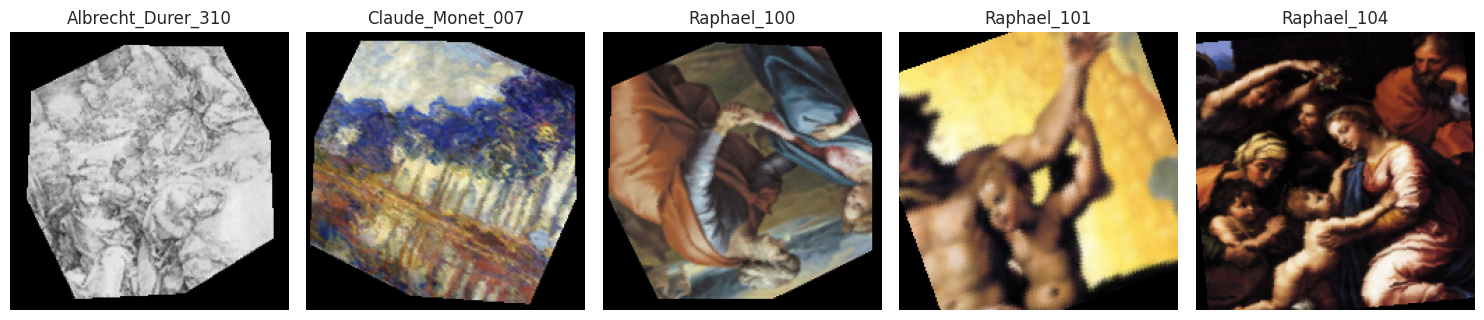

In [16]:
from PIL import Image

images_paths = [
    data_path / 'images' / 'train' / 'Albrecht_Durer' / 'Albrecht_Durer_310.jpg',
    data_path / 'images' / 'train' / 'Claude_Monet' / 'Claude_Monet_007.jpg',
    data_path / 'images' / 'train' / 'Raphael' / 'Raphael_100.jpg',
    data_path / 'images' / 'train' / 'Raphael' / 'Raphael_101.jpg',
    data_path / 'images' / 'train' / 'Raphael' / 'Raphael_104.jpg'
]

plt.figure(figsize=(15, 10)) 
for i, image_path in enumerate(images_paths):
    image = Image.open(image_path)
    augmented_image = train_aug_transform(image)
    
    plt.subplot(2, 5, i + 1)
    npimg = augmented_image.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    plt.title(f'{image_path.stem}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Выберите лучшую модель. Примените fine-tining модели
 на аугментированных данных. Получается ли улучшить качество?

In [29]:
checkpoint_callback = ModelCheckpoint(monitor='val_f1', mode='max')

wandb_logger = WandbLogger(project='artists_classification', log_model='all')

trainer = Trainer(
    logger=wandb_logger,                    # логгер из WandB
    #callbacks=[log_predictions_callback],    # callbacks: логгер предсказаний
               #checkpoint_callback],        # и сам чекпоинтер
    callbacks = [checkpoint_callback], 
    accelerator="gpu",                      # используем GPU
    max_epochs=20
)

model = FineTunedResNet(
    n_classes=big_artists.shape[0], lr=0.01, freeze_layers=15
)

trainer.fit(model, train_aug_loader, val_loader)

torch.save(model.state_dict(), 'aug_model.pth')
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | criterion         | CrossEntropyLoss  | 0      | train
1 | feature_extractor | Sequential        | 23.5 M | train
2 | classifier        | Sequential        | 1.1 M  | train
3 | train_f1          | MulticlassF1Score | 0      | train
4 | val_f1            | MulticlassF1Score | 0      | train
----------------------------------------------------------------
1.1 M     Trainable params
23.5 M    Non-trainable params
24.6 M    Total params
98.251    Total estimated model params size (MB)
158       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=20` reached.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
train_f1,▁▁▁▁▂▂▃▄▄▅▆▆▆▇▇█████
train_loss,█▇█▇▅▅▄▄▃▂▃▃▄▃▃▂▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇███
val_f1,▁▁▁▂▂▃▄▄▅▅▆▇▇▇▇▇████
val_loss,█▇▇▆▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁
epoch,19
train_f1,0.52054
train_loss,1.12168
trainer/global_step,879
val_f1,0.54709


**Вывод:**
f1 score только уменьшиля, он стал равным 0.547. Следует более аккуратно подбирать аугментации, по всей видимости смена перспективы только мешает. Возможно, поворот или симметрия не смогут дать сильный буст - модель уже предобучена тому, чтобы не замечать такую разницу. 

### 4. Несбалансированность классов
Расширим выборку до всех классов. Примените fine-tuning для расширенной выборки. Хорошо ли модель предсказывает малопредставленные классы?

Для подсчета F1 Score на редких классах после обучения определите у модели метод `test_step` и запустите `trainer.test(model, ...)` (до завершения запуска WandB!). На тесте разрешается записывать метки / предсказания в поля класса.

In [15]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_full_dataset,
                                              batch_size=batch_size,
                                              shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_full_dataset,
                                                batch_size=batch_size,
                                                shuffle=False, num_workers=8)

Сначала посчитаем число картин для каждого автора

In [16]:
train_class_counts = Counter(train_full_dataset.targets)

val_class_counts = Counter(val_full_dataset.targets)

total_class_counts = {class_idx: train_class_counts.get(class_idx, 0) + val_class_counts.get(class_idx, 0)
                      for class_idx in set(train_class_counts) | set(val_class_counts)}

class_counts = np.array(list(total_class_counts.values()))

weights = 1.0 / class_counts
weights = torch.tensor(weights, dtype=torch.float32)

Обучим модель

In [35]:
checkpoint_callback = ModelCheckpoint(monitor='val_f1', mode='max')

wandb_logger = WandbLogger(project='artists_classification', log_model='all')

trainer = Trainer(
    logger=wandb_logger,                    # логгер из WandB
    #callbacks=[log_predictions_callback],    # callbacks: логгер предсказаний
               #checkpoint_callback],        # и сам чекпоинтер
    callbacks = [checkpoint_callback], 
    accelerator="gpu",                      # используем GPU
    max_epochs=40
)

model_std_loss = FineTunedResNet(
    n_classes=artists.shape[0], lr=0.01, freeze_layers=15, class_counts=class_counts
)

trainer.fit(model_std_loss, train_loader, val_loader)

torch.save(model_std_loss.state_dict(), 'model_std_loss.pth')
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | criterion         | CrossEntropyLoss  | 0      | train
1 | feature_extractor | Sequential        | 23.5 M | train
2 | classifier        | Sequential        | 1.1 M  | train
3 | train_f1          | MulticlassF1Score | 0      | train
4 | val_f1            | MulticlassF1Score | 0      | train
----------------------------------------------------------------
1.1 M     Trainable params
23.5 M    Non-trainable params
24.6 M    Total params
98.331    Total estimated model params size (MB)
158       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=40` reached.


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇████
train_f1,▁▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█████
train_f1_rare_classes,▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
train_loss,██▇▇▇▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▃▃▃▃▂▂▂▃▃▂▂▂▃▂▂▂▂▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█████
val_f1,▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████
val_f1_rare_classes,▁▁▁▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇████
val_loss,█▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,39
train_f1,0.58021
train_f1_rare_classes,0.43194


В качестве решения проблемы несбалансированности классов можно взвешивать лосс. Если это [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), то можно указать в параметре `weight` веса классов. Также можно поменять стратегию семплирования при обучении, для этого можно использовать [WeightedRandomSampler](https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler) в качестве параметра `sampler` в `dataloader`. Подумайте, как еще можно можно решить эту проблему. Попробуйте одну из стратегий. Получается ли улучшить качество?

Теперь если взвешивать лосс

In [38]:
checkpoint_callback = ModelCheckpoint(monitor='val_f1', mode='max')

wandb_logger = WandbLogger(project='artists_classification', log_model='all')

trainer = Trainer(
    logger=wandb_logger,                    # логгер из WandB
    #callbacks=[log_predictions_callback],    # callbacks: логгер предсказаний
               #checkpoint_callback],        # и сам чекпоинтер
    callbacks = [checkpoint_callback], 
    accelerator="gpu",                      # используем GPU
    max_epochs=40
)

model_weight_loss = FineTunedResNet(
    n_classes=artists.shape[0], lr=0.01, freeze_layers=15, class_counts=class_counts
)
weights = 1. / class_counts
weights = torch.tensor(weights, dtype=torch.float32)
model_weight_loss.criterion = nn.CrossEntropyLoss(weight=weights)

trainer.fit(model_weight_loss, train_loader, val_loader)

torch.save(model_weight_loss.state_dict(), 'model_weight_loss.pth')
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/juequ/.local/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | criterion         | CrossEntropyLoss  | 0      | train
1 | feature_extractor | Sequential        | 23.5 M | train
2 | classifier        | Sequential        | 1.1 M  | train
3 | train_f1          | MulticlassF1Score | 0      | train
4 | val_f1            | MulticlassF1Score | 0      | train
----------------------------------------------------------------
1.1 M     Trainable params
23.5 M    Non-trainable params
24.6 M    Total params

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=40` reached.


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
train_f1,▁▂▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
train_f1_rare_classes,▁▂▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
train_loss,████▇▇▆▇▆▆▆▅▅▄▄▃▄▄▃▃▃▃▃▂▂▃▃▂▂▂▂▁▂▂▁▁▁▁▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
val_f1,▁▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████
val_f1_rare_classes,▁▂▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_loss,██▇▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,39
train_f1,0.64427
train_f1_rare_classes,0.60731


Итак, f1 сильно выросла

f1 на валидации:

0.524 против 0.482

f1 редких классов:

0.477 против 0.358

Стоит применять еще больше методов для улучшения, в т.ч. улучшенное сэмплирование. Как видно, это может дать сильный прирост

<a name=vis></a>
### 5. Визуализация запусков и выводы



Визуализируйте графики лосса и метрики всех релевантных запусков. Для этого воспользуйтесь `wandb.Api()`, см. семинар. Сравните и сделайте выводы.

Сначала визуализируем модели, которые работали только с крупными художниками

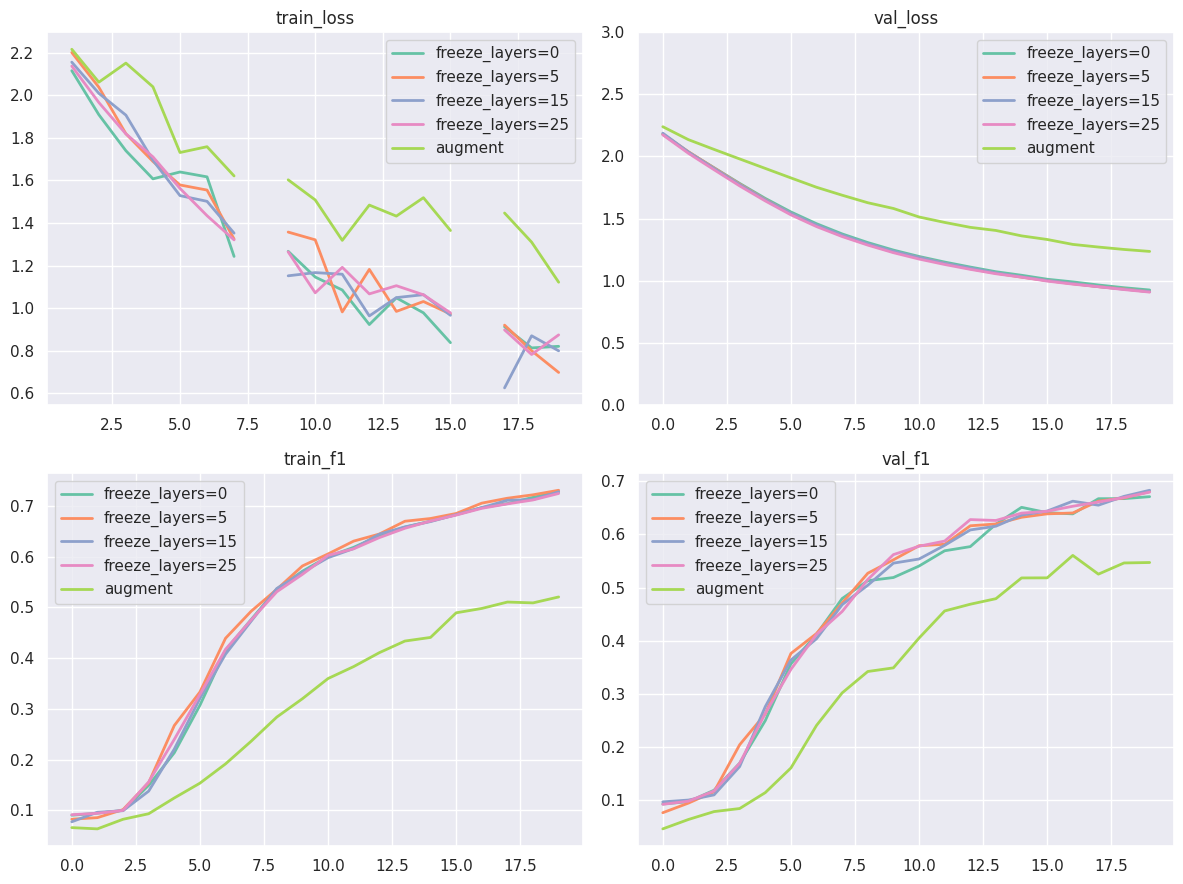

In [44]:
runs = wandb.Api().runs("artists_classification")
subplot_names = np.array([['train_loss', 'val_loss'],
                          ['train_f1', 'val_f1']])

fig, axs = plt.subplots(2, 2, figsize=(12, 9))
lw = 2
for i, run in enumerate(runs):
    if 'loss' in run.name:
        continue
    df = run.history().groupby('epoch').mean(numeric_only=True)
    for k in range(2):
        for m in range(2):
            axs[k, m].set_title(subplot_names[k, m])
            axs[k, m].plot(df[subplot_names[k, m]], lw=lw, label=run.name)
            axs[k, m].legend()
    axs[0, 1].set_ylim((0, 3))
plt.tight_layout()

Теперь две последние модели, которые работали со всем датасетом

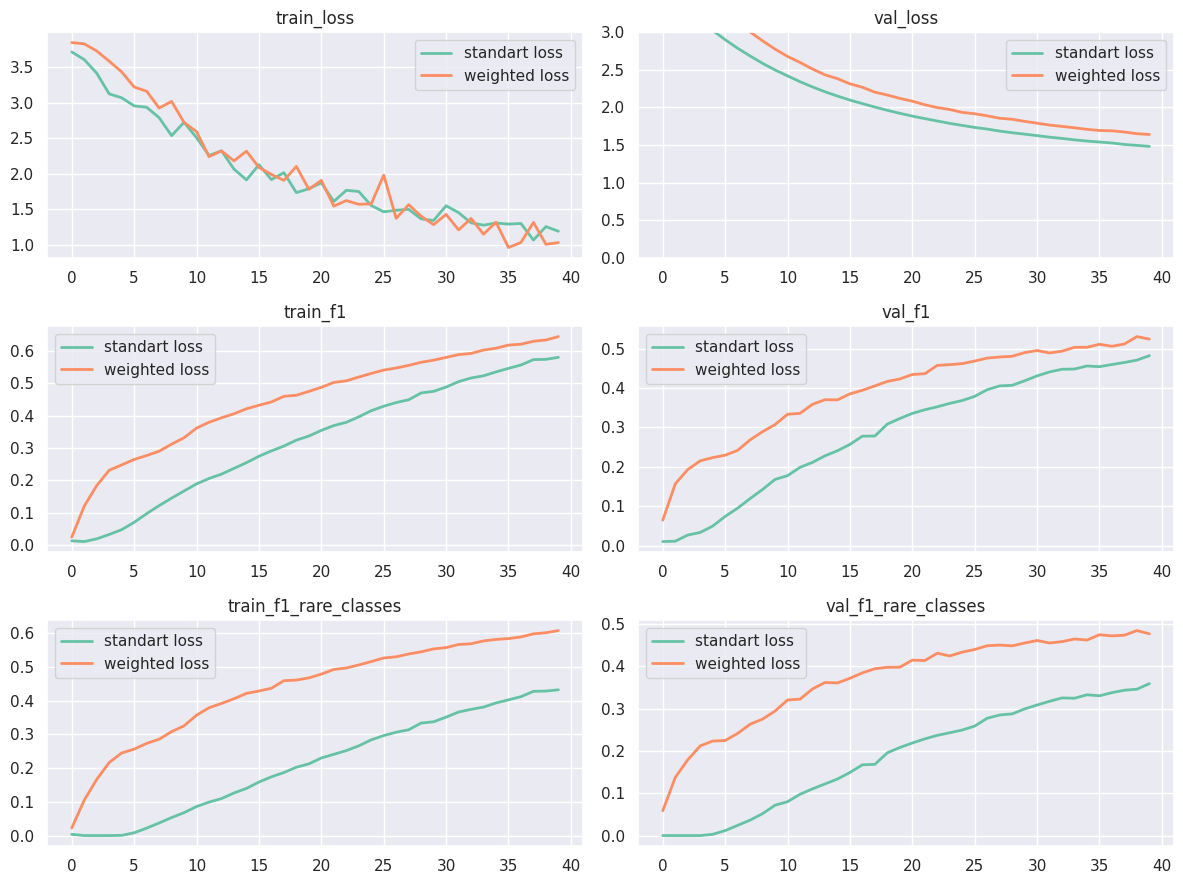

In [54]:
runs = wandb.Api().runs("artists_classification")
subplot_names = np.array([['train_loss', 'val_loss'],
                          ['train_f1', 'val_f1'], 
                          ['train_f1_rare_classes', 'val_f1_rare_classes']])

fig, axs = plt.subplots(3, 2, figsize=(12, 9))
lw = 2
for i, run in enumerate(runs):
    if 'loss' not in run.name:
        continue
    df = run.history().groupby('epoch').mean(numeric_only=True)
    for k in range(3):
        for m in range(2):
            axs[k, m].set_title(subplot_names[k, m])
            axs[k, m].plot(df[subplot_names[k, m]], lw=lw, label=run.name)
            axs[k, m].legend()
    axs[0, 1].set_ylim((0, 3))
plt.tight_layout()

Сделайте общий вывод по задаче.

**Вывод:**

С помощью Fine-Tuning можно использовать уже предобученные модели. Во-первых, требуется меньше времени на их дообучение. Во-вторых, уже есть готовая архитектура, не нужно строить ее с нуля. 

Стоит аккуратно работать с аугментацией данных. Не всегда мы можем сильно шевелить входные данные - в данной задаче мы сильно привязаны к конкретному стилю художника, поэтому мы не можем например сильно менять цветовую палитру, добавлять шум и подобное

Взвешенный лосс позволяет невелировать несбаланированность класса и сильно улучшить модель